
# Time Series Cource Project Source Code

Mohammad Zarei & Maryam Shirban - 
Spring 1402

## 3. Multivariate Forecasting

In [2]:
import numpy as np
import pandas as pd
# import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os, random

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error,\
                            mean_absolute_error, mean_absolute_percentage_error,\
                            r2_score
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from xgboost import XGBRegressor

# from keras.layers import InputLayer, LSTM, Flatten, Dense, Reshape, Lambda,\
#                         RepeatVector, TimeDistributed, Layer, Dropout
# from keras.models import Model, Sequential
# from keras.optimizers import Adam
# from keras.regularizers import l2
# from keras import backend as K

np.random.seed(123)

In [3]:
# Make results reproducable
def reset_random_seeds(seed = 42):
    np.random.seed(seed)
    # tf.random.set_seed(seed)
    random.seed(seed)
    # os.environ['TF_DETERMINISTIC_OPS'] = '1'

reset_random_seeds()

In [4]:
# Load merged data from the previous section
data = pd.read_csv('ts_data/food_demand_merged.csv')
data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian


In [5]:
data.shape

(456548, 15)

In [6]:
# convert categorical data to numerical values
data['center_type'] = data['center_type'].astype('category').cat.codes + 1
data['category'] = data['category'].astype('category').cat.codes + 1
data['cuisine'] = data['cuisine'].astype('category').cat.codes + 1
data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,3,2.0,1,4
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,3,2.0,1,4
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,3,2.0,1,4
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,3,2.0,1,2
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,3,2.0,1,2


In [7]:
# add new column
data_1 = data.copy()

#Discount Percent
data_1['discount percent'] = ((data_1['base_price']-data_1['checkout_price'])/data_1['base_price'])*100

# remove id column
data_1.drop(columns = ['id'], inplace = True)

In [8]:
data_1.shape

(456548, 15)

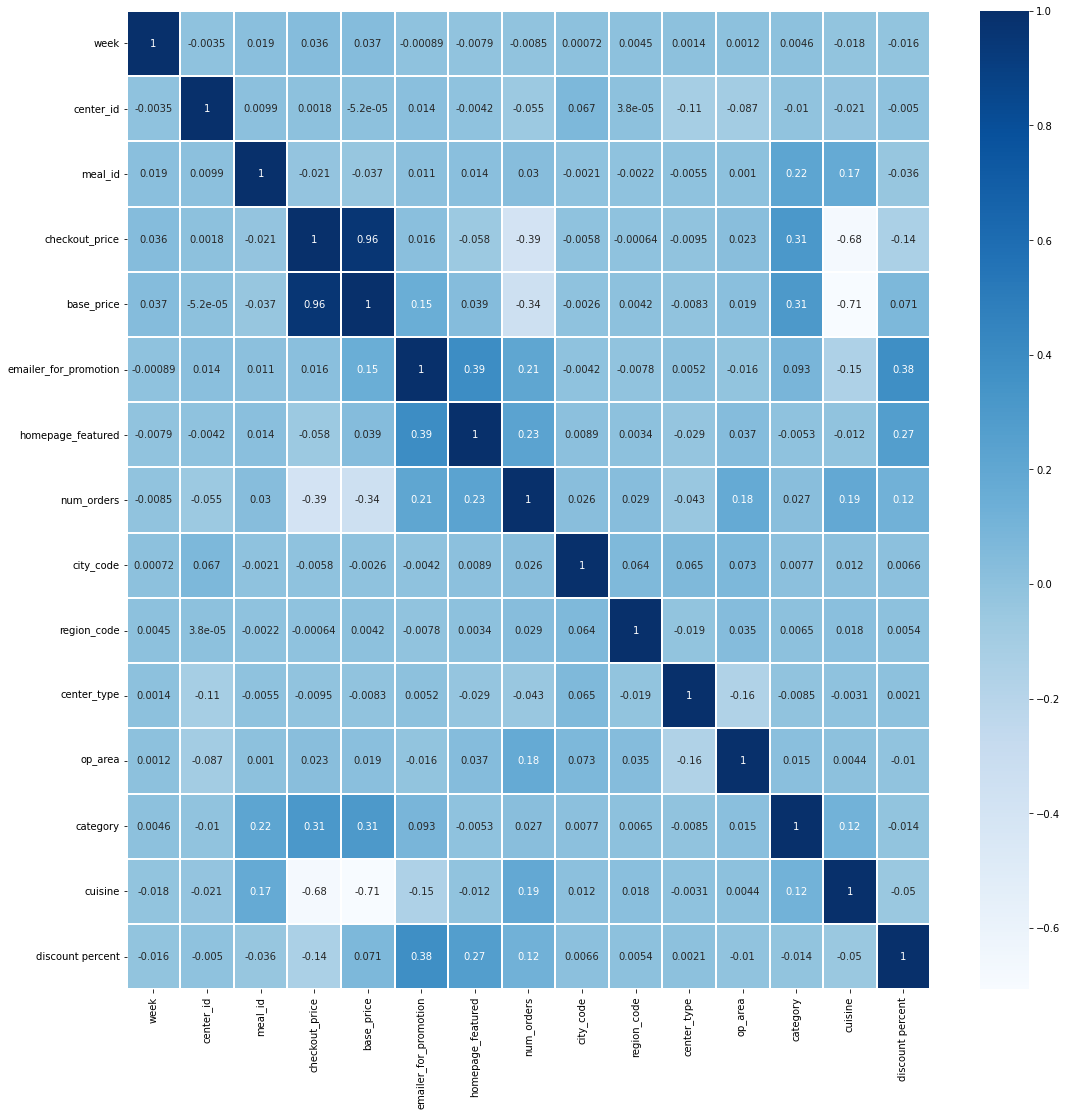

In [9]:
# Correlation of features
plt.figure(figsize = (18, 18))
corr_meat = data_1.corr(method='spearman')

# Customize the heatmap of the corr_meat correlation matrix
sns.heatmap(corr_meat,
           annot=True,
           linewidths=0.4,
           annot_kws={'size': 10},
           cmap = 'Blues');

plt.xticks(rotation=90);
plt.yticks(rotation=0);

In [10]:
# split data to train and test sets
df = data_1.copy()

train = df[df['week'] <= 135].copy()
test = df[df['week'] >= 136].copy()

X_train = train.drop(columns= ['num_orders'])
Y_train = train['num_orders'].to_frame()
X_test = test.drop(columns= ['num_orders'])
Y_test = test['num_orders'].to_frame()

In [11]:
# Define Metrics
def evaluate(y_true, y_pred):

    # Mean Error
    ME = np.mean(np.array(y_true).squeeze() - np.array(y_pred).squeeze())

    # Mean Squared Error
    MSE = mean_squared_error(y_true, y_pred)

    # Root Mean Squared Error
    RMSE = np.sqrt(MSE)

    # Mean Absolute Error
    MAE = mean_absolute_error(y_true, y_pred)

    # Mean Absolute Percentage Error
    MAPE = mean_absolute_percentage_error(y_true, y_pred)

    # Min Max Error (Normalized Absolute Error)
    minmax_difference = np.max(np.array(y_true).squeeze()) - np.min(np.array(y_true).squeeze())
    MME = MAE / minmax_difference

    # R-Squared Statistic
    r_squared = r2_score(y_true, y_pred)

    return ME, MSE, RMSE, MAE, MAPE, MME, r_squared

In [11]:
# Linear Regression
model = make_pipeline(StandardScaler(),LinearRegression())
model.fit(X_train,Y_train)

Y_train_fitted = model.predict(X_train)
Y_test_pred = model.predict(X_test)

Y_train_fitted[Y_train_fitted < 0] = 0
Y_test_pred[Y_test_pred < 0] = 0

In [12]:
# Model Evaluation
metrics_names = ['ME', 'MSE', 'RMSE', 'MAE', 'MAPE', 'MME', 'R-Squared']
results = pd.DataFrame(columns = metrics_names)

results.loc['train'] = evaluate(Y_train , Y_train_fitted)
results.loc['test'] = evaluate(Y_test, Y_test_pred)
    
results.round(2)


,ME,MSE,RMSE,MAE,MAPE,MME,R-Squared
train,-3.84,119558.96,345.77,192.47,2.07,0.01,0.26
test,-14.22,65983.07,256.87,170.77,1.95,0.05,0.14


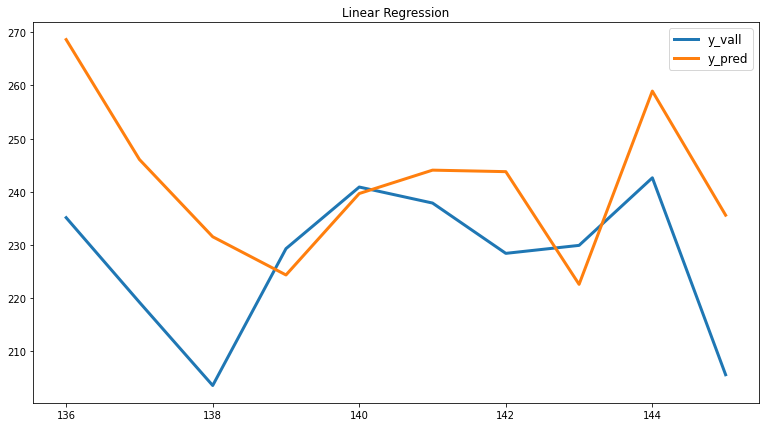

In [13]:
# Showing prediction with Linear Regression
plt.figure(figsize=(13,7))
sns.lineplot(ci=None, x=X_test['week'].values.squeeze(), y=Y_test.values.squeeze(), linewidth=3).set_title('Linear Regression')
sns.lineplot(ci=None, x=X_test['week'].values.squeeze(), y=Y_test_pred.squeeze(), linewidth=3 ).set_title('Linear Regression')
plt.legend(['y_vall', 'y_pred'] , fontsize='12')
plt.show()

In [14]:
# Random Forest Regression
model = make_pipeline(StandardScaler(),RandomForestRegressor())
model.fit(X_train,Y_train.values.squeeze())

Y_train_fitted = model.predict(X_train)
Y_test_pred = model.predict(X_test)

Y_train_fitted[Y_train_fitted < 0] = 0
Y_test_pred[Y_test_pred < 0] = 0

In [15]:
# Model Evaluation
metrics_names = ['ME', 'MSE', 'RMSE', 'MAE', 'MAPE', 'MME', 'R-Squared']
results = pd.DataFrame(columns = metrics_names)

results.loc['train'] = evaluate(Y_train , Y_train_fitted)
results.loc['test'] = evaluate(Y_test, Y_test_pred)
    
results.round(2)

,ME,MSE,RMSE,MAE,MAPE,MME,R-Squared
train,-0.73,3027.36,55.02,25.51,0.18,0.00,0.98
test,-17.07,29461.88,171.64,80.27,0.61,0.02,0.61


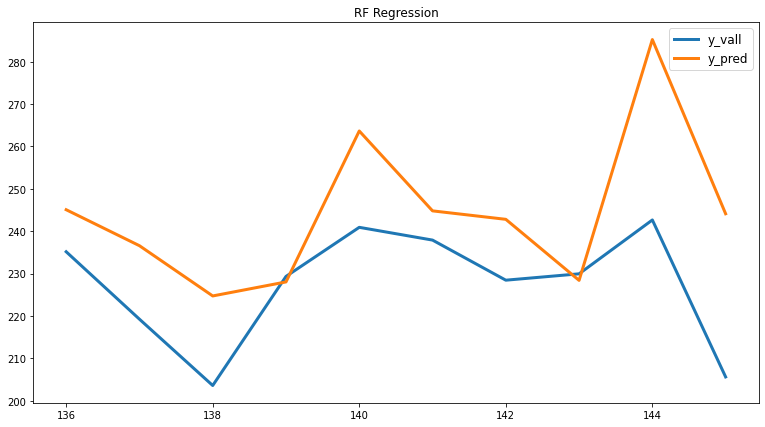

In [16]:
# Showing prediction
plt.figure(figsize=(13,7))
sns.lineplot(ci=None, x=X_test['week'].values.squeeze(), y=Y_test.values.squeeze(), linewidth=3).set_title('RF Regression')
sns.lineplot(ci=None, x=X_test['week'].values.squeeze(), y=Y_test_pred.squeeze(), linewidth=3 ).set_title('RF Regression')
plt.legend(['y_vall', 'y_pred'] , fontsize='12')
plt.show()

In [12]:
# XG Boost
model = make_pipeline(StandardScaler(),XGBRegressor())
model.fit(X_train, Y_train.values.squeeze())

Y_train_fitted = model.predict(X_train)
Y_test_pred = model.predict(X_test)

Y_train_fitted[Y_train_fitted < 0] = 0
Y_test_pred[Y_test_pred < 0] = 0

In [13]:
# Model Evaluation
metrics_names = ['ME', 'MSE', 'RMSE', 'MAE', 'MAPE', 'MME', 'R-Squared']
results = pd.DataFrame(columns = metrics_names)

results.loc['train'] = evaluate(Y_train , Y_train_fitted)
results.loc['test'] = evaluate(Y_test, Y_test_pred)
    
results.round(2)

,ME,MSE,RMSE,MAE,MAPE,MME,R-Squared
train,-0.45,19981.73,141.36,78.80,0.63,0.01,0.88
test,-5.29,28019.25,167.39,91.24,0.76,0.03,0.63


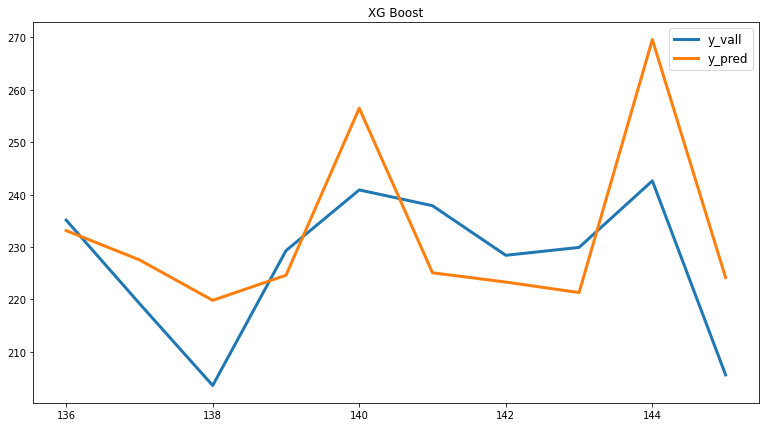

In [14]:
# Showing prediction
plt.figure(figsize=(13,7))
sns.lineplot(ci=None, x=X_test['week'].values.squeeze(), y=Y_test.values.squeeze(), linewidth=3).set_title('XG Boost')
sns.lineplot(ci=None, x=X_test['week'].values.squeeze(), y=Y_test_pred.squeeze(), linewidth=3 ).set_title('XG Boost')
plt.legend(['y_vall', 'y_pred'] , fontsize='12')
plt.show()

In [16]:
X_train.shape

(423727, 14)

In [18]:
lookback_period = 10
X_train_ = np.array([X_train[j : j + lookback_period] for j in range(len(X_train) - lookback_period)])

In [19]:
X_train_.shape

(423717, 10, 14)

In [21]:
Y_train_ = np.array([Y_train[j : j + lookback_period] for j in range(len(Y_train) - lookback_period)])

In [22]:
Y_train_.shape

(423717, 10, 1)

In [23]:
import numpy as np
from keras.models import Sequential
from keras.layers import GRU, Dense

# Generate sample multivariate time series data
# Assume X_train_ is a 3D numpy array with shape (num_samples, num_timesteps, num_features)
# Assume Y_train_ is a 2D numpy array with shape (num_samples, num_output_features)

# Define the GRU model
model = Sequential()
model.add(GRU(units=64, input_shape=(X_train_.shape[1], X_train_.shape[2])))
model.add(Dense(units=Y_train_.shape[1]))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train_, Y_train_, epochs=10, batch_size=32)


Epoch 1/10
13242/13242 [==============================] - 186s 14ms/step - loss: 174563.3438
Epoch 2/10
13242/13242 [==============================] - 178s 13ms/step - loss: 161332.2188
Epoch 3/10
13242/13242 [==============================] - 174s 13ms/step - loss: 161322.6250
Epoch 4/10
13242/13242 [==============================] - 177s 13ms/step - loss: 161033.0469
Epoch 5/10
13242/13242 [==============================] - 184s 14ms/step - loss: 160708.5156
Epoch 6/10
13242/13242 [==============================] - 185s 14ms/step - loss: 160197.7500
Epoch 7/10
13242/13242 [==============================] - 180s 14ms/step - loss: 159516.0625
Epoch 8/10
13242/13242 [==============================] - 174s 13ms/step - loss: 159039.3906
Epoch 9/10
13242/13242 [==============================] - 168s 13ms/step - loss: 158597.9375
Epoch 10/10
13242/13242 [==============================] - 183s 14ms/step - loss: 158210.9531


In [11]:


# Select three cases randomly from each center type
df_by_cases = [group.values for _, group in df.groupby(['center_id', 'meal_id'])]

In [12]:
df_by_cases[0].shape

(145, 15)

In [8]:
# convert week column to datetime index
df = data_1.copy()

start_date = dt.datetime(2020, 1, 1)

df['date'] = df['week'].apply(lambda x: start_date + dt.timedelta(weeks=x))


In [9]:
df.head()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,discount percent,date
0,1,55,1885,136.83,152.29,0,0,177,647,56,3,2.0,1,4,10.151684,2020-01-08
1,1,55,1993,136.83,135.83,0,0,270,647,56,3,2.0,1,4,-0.736214,2020-01-08
2,1,55,2539,134.86,135.86,0,0,189,647,56,3,2.0,1,4,0.736052,2020-01-08
3,1,55,2139,339.50,437.53,0,0,54,647,56,3,2.0,1,2,22.405321,2020-01-08
4,1,55,2631,243.50,242.50,0,0,40,647,56,3,2.0,1,2,-0.412371,2020-01-08


In [11]:
# Make sure df is indexed by date
df = df.set_index('date')

In [12]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

In [14]:
model = VAR(X_train.to_numpy())
model_fit = model.fit(maxlags=15, ic='aic')

In [13]:
# Check for stationarity and difference if necessary
def check_stationarity(series, signif=0.05):
    adf_test = adfuller(series, autolag='AIC')
    p_value = adf_test[1]
    if p_value <= signif:
        return True
    else:
        return False

In [14]:
check_stationarity(df['num_orders'])

KeyboardInterrupt: 

In [15]:
for i in df.columns:
    print(f'{i} : {check_stationarity(df[i])}')

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd




# Choose only numeric columns, excluding 'num_orders'
columns = [col for col in df.columns if df[col].dtype in [np.float64, np.int64] and col != 'num_orders']
df_subset = df[columns + ['num_orders']]



for column in df_subset.columns:
    if not check_stationarity(df_subset[column]):
        df_subset[column] = df_subset[column].diff().dropna()

# Split into train and test sets
n_obs = 10 # We'll predict the last 10 observations
df_train, df_test = df_subset[0:-n_obs], df_subset[-n_obs:]

model = VAR(df_train)
model_fit = model.fit(maxlags=15, ic='aic')

# Make prediction
prediction = model_fit.forecast(model_fit.y, steps=n_obs)


In [11]:
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [19]:
model = Sequential()
model.add(Dense(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [20]:
history = model.fit(X_train, Y_train, epochs=50, batch_size=128, verbose=2, shuffle=False)


Epoch 1/50
3311/3311 - 11s - loss: 1217057.5000 - 11s/epoch - 3ms/step
Epoch 2/50
3311/3311 - 8s - loss: 175736.5938 - 8s/epoch - 2ms/step
Epoch 3/50
3311/3311 - 7s - loss: 176955.6875 - 7s/epoch - 2ms/step
Epoch 4/50
3311/3311 - 7s - loss: 171394.3750 - 7s/epoch - 2ms/step
Epoch 5/50
3311/3311 - 7s - loss: 167729.9531 - 7s/epoch - 2ms/step
Epoch 6/50
3311/3311 - 7s - loss: 164952.9531 - 7s/epoch - 2ms/step
Epoch 7/50
3311/3311 - 7s - loss: 162745.7344 - 7s/epoch - 2ms/step
Epoch 8/50
3311/3311 - 7s - loss: 160890.9844 - 7s/epoch - 2ms/step
Epoch 9/50
3311/3311 - 7s - loss: 159274.6250 - 7s/epoch - 2ms/step
Epoch 10/50
3311/3311 - 7s - loss: 157904.0469 - 7s/epoch - 2ms/step
Epoch 11/50
3311/3311 - 7s - loss: 156689.8906 - 7s/epoch - 2ms/step
Epoch 12/50
3311/3311 - 7s - loss: 155587.4062 - 7s/epoch - 2ms/step
Epoch 13/50
3311/3311 - 7s - loss: 154580.3438 - 7s/epoch - 2ms/step
Epoch 14/50
3311/3311 - 8s - loss: 153666.1875 - 8s/epoch - 2ms/step
Epoch 15/50
3311/3311 - 11s - loss: 1528

In [14]:
Y_test_pred = model.predict(X_test)

1026/1026 [==============================] - 6s 4ms/step


In [15]:
model.evaluate(X_test, Y_test)

1026/1026 [==============================] - 6s 4ms/step - loss: 77688.0547


77688.0546875

In [18]:
r2_score(Y_test, Y_test_pred)

-0.015476166302632821

In [17]:
evaluate(Y_test, Y_test_pred)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [9]:
# Select features to be used in the LSTM model and convert to values
selected_features = data[['num_orders', 'checkout_price', 'base_price', 'op_area']]
data_values = selected_features.values

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data_values)

In [13]:
# Let's split data into features (X) and target (y)
X = scaled.drop('num_orders', axis=1)
y = scaled['num_orders']

# Reshape input to be 3D [samples, timesteps, features]
X = X.values.reshape((X.shape[0], 1, X.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the LSTM model
history = model.fit(X, y, epochs=50, batch_size=72, validation_split=0.2, verbose=2, shuffle=False)

AttributeError: 'numpy.ndarray' object has no attribute 'drop'

In [10]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

reframed = series_to_supervised(scaled, 1, 1)

In [11]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

NameError: name 'n_features' is not defined

In [7]:
# split data to train and test sets
train = data[data['week'] <= 135].copy()
test = data[data['week'] >= 136].copy()

In [8]:
# reshape input to be [samples, time steps, features]
train = np.reshape(train, (train.shape[0], 1, train.shape[1]))
test = np.reshape(test, (test.shape[0], 1, test.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(1, train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train, epochs=50, batch_size=1, verbose=2)

ValueError: Must pass 2-d input. shape=(423727, 1, 33)

In [4]:
# uniqure center-meal pairs
cases = data.loc[:, ['center_id', 'meal_id', 'center_type']].drop_duplicates()
cases.reset_index(inplace = True, drop = True)
cases

,center_id,meal_id,center_type
0,55,1885,TYPE_C
1,55,1993,TYPE_C
2,55,2539,TYPE_C
3,55,2139,TYPE_C
4,55,2631,TYPE_C
...,...,...,...
3592,162,2577,TYPE_C
3593,145,2104,TYPE_A
3594,61,2956,TYPE_A
3595,145,1571,TYPE_A


In [5]:
# Select three cases randomly from each center type
cases_by_center_type = [group for _, group in cases.groupby('center_type')]

n_cases = 3
selected_cases = {}

for i in range(n_cases):
    selected_cases[f'Case_{i + 1}'] = np.random.choice(cases_by_center_type[i].index)

print(list(selected_cases.values()))


[2703, 1155, 1938]


In [6]:
# get data of each three cases and count NAs
cases_data = {}
for i in range(n_cases):
    case = selected_cases[f'Case_{i + 1}']
    center_id, meal_id, center_type = cases.iloc[case]

    data_ = data.loc[(data['center_id'] == center_id) & (data['meal_id'] == meal_id)].copy()
    data_.set_index('week', inplace = True, drop = True)

    orders = pd.DataFrame(index = np.arange(data['week'].max()) + 1)
    orders.rename_axis('week', axis = 0, inplace = True)
    orders['num_orders'] = data_['num_orders']

    cases_data[f'Case_{i + 1}'] = orders
    
    print(f'Case {i + 1} : center_id = {center_id}, meal_id = {meal_id}, center_type = {center_type}, n_NAs = {int(orders.isna().sum())}')


Case 1 : center_id = 132, meal_id = 1803, center_type = TYPE_A, n_NAs = 2
Case 2 : center_id = 75, meal_id = 2867, center_type = TYPE_B, n_NAs = 5
Case 3 : center_id = 72, meal_id = 2581, center_type = TYPE_C, n_NAs = 3


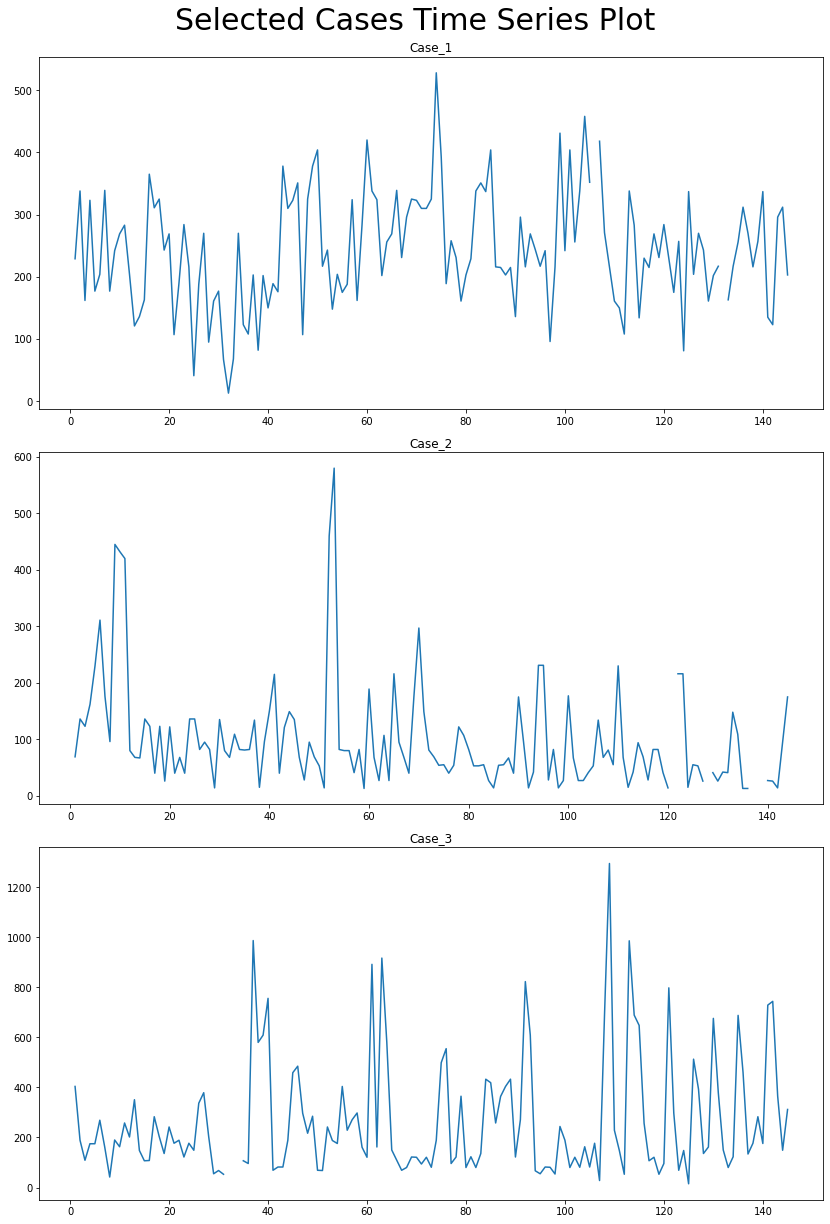

In [7]:
# Pot Cases Data
fig , axs = plt.subplots(nrows = n_cases, ncols = 1, figsize = (13, n_cases * 6))

for i in range(n_cases):
    data = cases_data[f'Case_{i + 1}']
    axs[i].plot(data)
    axs[i].set_title(f'Case_{i + 1}')

plt.tight_layout(pad = 6, h_pad = 1)
plt.suptitle('Selected Cases Time Series Plot', fontsize = 30)
plt.savefig('ts_figures/Time_Series_Selected_Cases_before_Imputation.jpg', dpi = 300)
plt.show()

In [8]:
# Deal with NA values
for i in range(n_cases):
    data_ = cases_data[f'Case_{i + 1}']
    data_.interpolate(method = 'linear', inplace = True)
    cases_data[f'Case_{i + 1}'] = data_
    print(f'Case {i + 1} - number of NAs: {int(data_.isna().sum())}')

Case 1 - number of NAs: 0
Case 2 - number of NAs: 0
Case 3 - number of NAs: 0


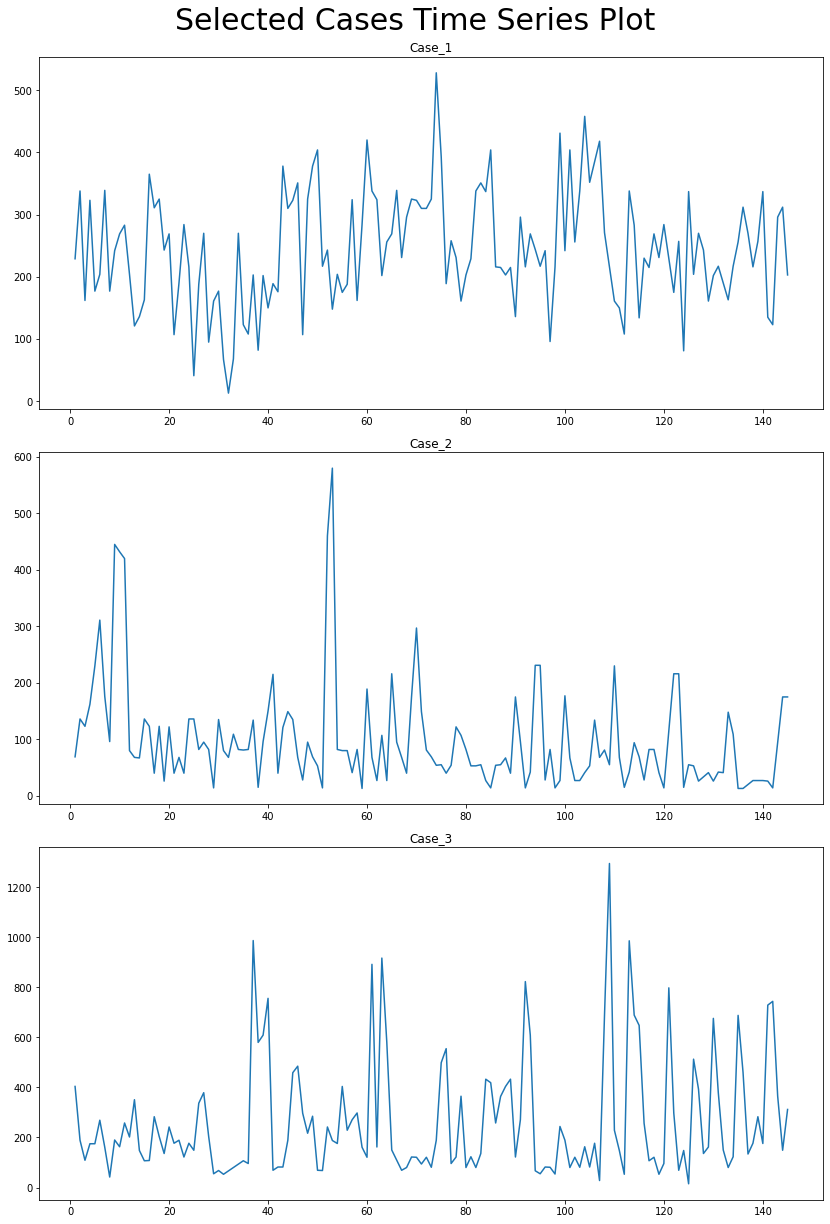

In [9]:
# Pot Cases Data after dealing with NAs
fig , axs = plt.subplots(nrows = n_cases, ncols = 1, figsize = (13, n_cases * 6))

for i in range(n_cases):
    data = cases_data[f'Case_{i + 1}']
    axs[i].plot(data)
    axs[i].set_title(f'Case_{i + 1}')

plt.tight_layout(pad = 6, h_pad = 1)
plt.suptitle('Selected Cases Time Series Plot', fontsize = 30)
plt.savefig('ts_figures/Time_Series_Selected_Cases_after_Imputation.jpg', dpi = 300)
plt.show()

In [10]:
# Split data to train and test sets
data_ = {}
set_names = ['train', 'test']

for set_name in set_names:
    data_[set_name] = {}
    
for i in range(n_cases):
    data_['train'][f'Case_{i + 1}'] = cases_data[f'Case_{i + 1}'].loc[:136]
    data_['test'][f'Case_{i + 1}'] = cases_data[f'Case_{i + 1}'].loc[136:]

Text(0.5, 0.98, 'Selected Cases Time Series Plot')

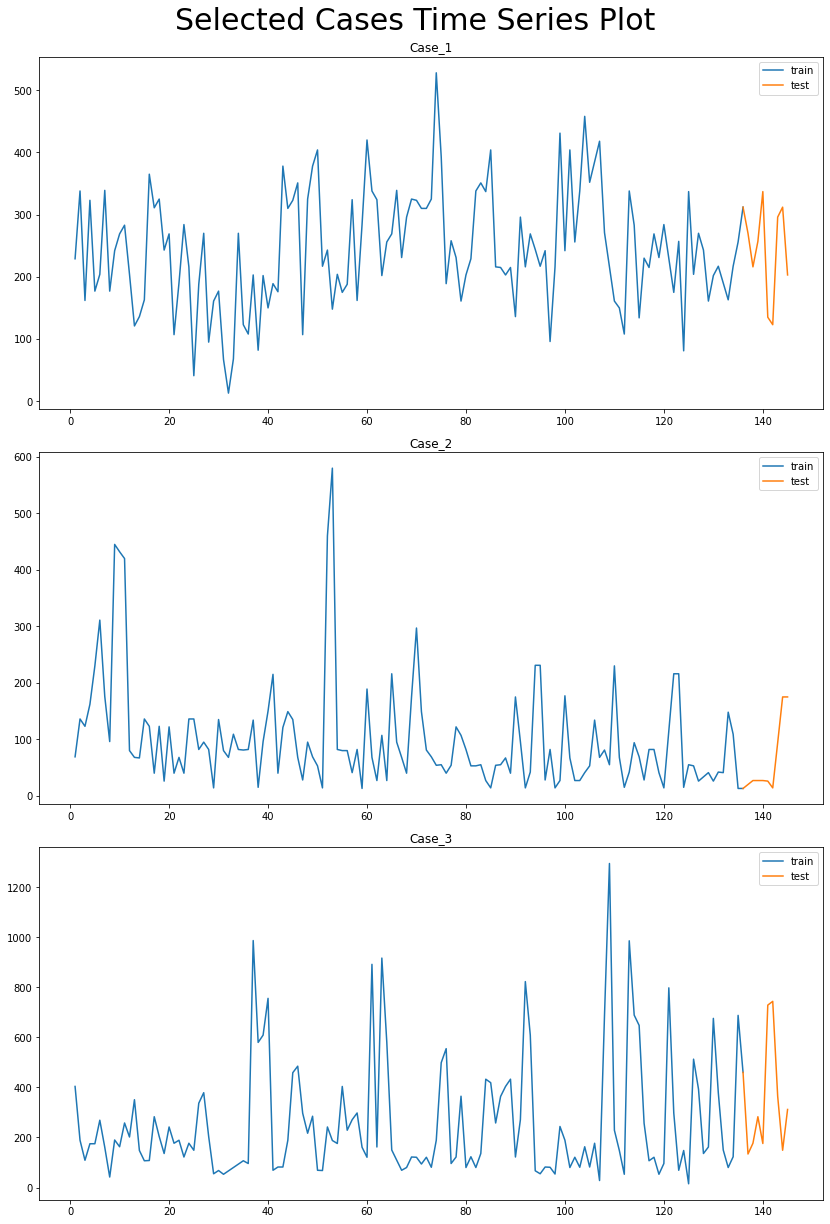

In [11]:
# Pot Cases Data with different color for test set
fig , axs = plt.subplots(nrows = n_cases, ncols = 1, figsize = (13, n_cases * 6))

for i in range(n_cases):
    train = data_['train'][f'Case_{i + 1}']
    test = data_['test'][f'Case_{i + 1}']
    axs[i].plot(train, label = 'train')
    axs[i].plot(test, label = 'test')
    axs[i].set_title(f'Case_{i + 1}')
    axs[i].legend()

plt.tight_layout(pad = 6, h_pad = 1)
plt.suptitle('Selected Cases Time Series Plot', fontsize = 30)

In [12]:
# Define Metrics
def evaluate(y_true, y_pred):

    # Mean Error
    ME = np.mean(y_true.values - y_pred.values)

    # Mean Squared Error
    MSE = mean_squared_error(y_true, y_pred)

    # Root Mean Squared Error
    RMSE = np.sqrt(MSE)

    # Mean Absolute Error
    MAE = mean_absolute_error(y_true, y_pred)

    # Mean Absolute Percentage Error
    MAPE = mean_absolute_percentage_error(y_true, y_pred)

    # Min Max Error (Normalized Absolute Error)
    minmax_difference = np.max(y_true.values) - np.min(y_pred.values)
    MME = MAE / minmax_difference

    # R-Squared Statistic
    r_squared = r2_score(y_true, y_pred)

    return ME, MSE, RMSE, MAE, MAPE, MME, r_squared

### 2.1. First Order Exponential Smoothing

In [13]:
# Fit Models
fitted_models = {}

for i in range(n_cases):
    df = data_['train'][f'Case_{i + 1}'].copy()
    
    model = SimpleExpSmoothing(df)
    fitted_model = model.fit()
    fitted_models[f'Case_{i + 1}'] = fitted_model

    summary = fitted_model.summary()
    print(f'Case_{i + 1} fitted model summary:')
    print(summary)


Case_1 fitted model summary:
                       SimpleExpSmoothing Model Results                       
Dep. Variable:             num_orders   No. Observations:                  136
Model:             SimpleExpSmoothing   SSE                        1056099.063
Optimized:                       True   AIC                           1222.212
Trend:                           None   BIC                           1228.037
Seasonal:                        None   AICC                          1222.517
Seasonal Periods:                None   Date:                 Sat, 24 Jun 2023
Box-Cox:                        False   Time:                         23:06:28
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.2325285                alpha                 True
initial_level          

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [14]:
# Model Evaluation
metrics_names = ['ME', 'MSE', 'RMSE', 'MAE', 'MAPE', 'MME', 'R-Squared']
indices = pd.MultiIndex.from_product([list(cases_data.keys()), ['train', 'test']], 
                                    names = ['Cases', 'sets'])

results = pd.DataFrame(columns = metrics_names, index = indices)

for i in range(n_cases):
    fitted_model = fitted_models[f'Case_{i + 1}']

    # train set evaluation
    train_actual = data_['train'][f'Case_{i + 1}']
    fitted = fitted_model.fittedvalues
    results.loc[(f'Case_{i + 1}', 'train'), :] = evaluate(train_actual, fitted)

    # test set evaluation
    test_actual = data_['test'][f'Case_{i + 1}']
    forecasted = fitted_model.forecast(10)
    results.loc[(f'Case_{i + 1}', 'test'), :] = evaluate(test_actual, forecasted)
    
results.round(2)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In t

ME           MSE        RMSE         MAE      MAPE  \
Cases  sets                                                               
Case_1 train   0.278604   7765.434289   88.121702    70.55508  0.445485   
       test    8.289465   5107.605234   71.467512   63.137893  0.312781   
Case_2 train   -0.55663   8826.966921   93.951939   65.623643  1.180722   
       test    6.647774   3839.552901   61.964126    50.26089  1.332005   
Case_3 train  -8.840438  59704.011311  244.344043  183.617797  1.318549   
       test   37.954045  47871.799555  218.796251  169.689191  0.575235   

                   MME R-Squared  
Cases  sets                       
Case_1 train   0.16751  0.084717  
       test   0.636538 -0.013637  
Case_2 train  0.123318  0.010463  
       test   0.412489 -0.011644  
Case_3 train  0.162156 -0.069824  
       test   0.395496 -0.031025

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In t

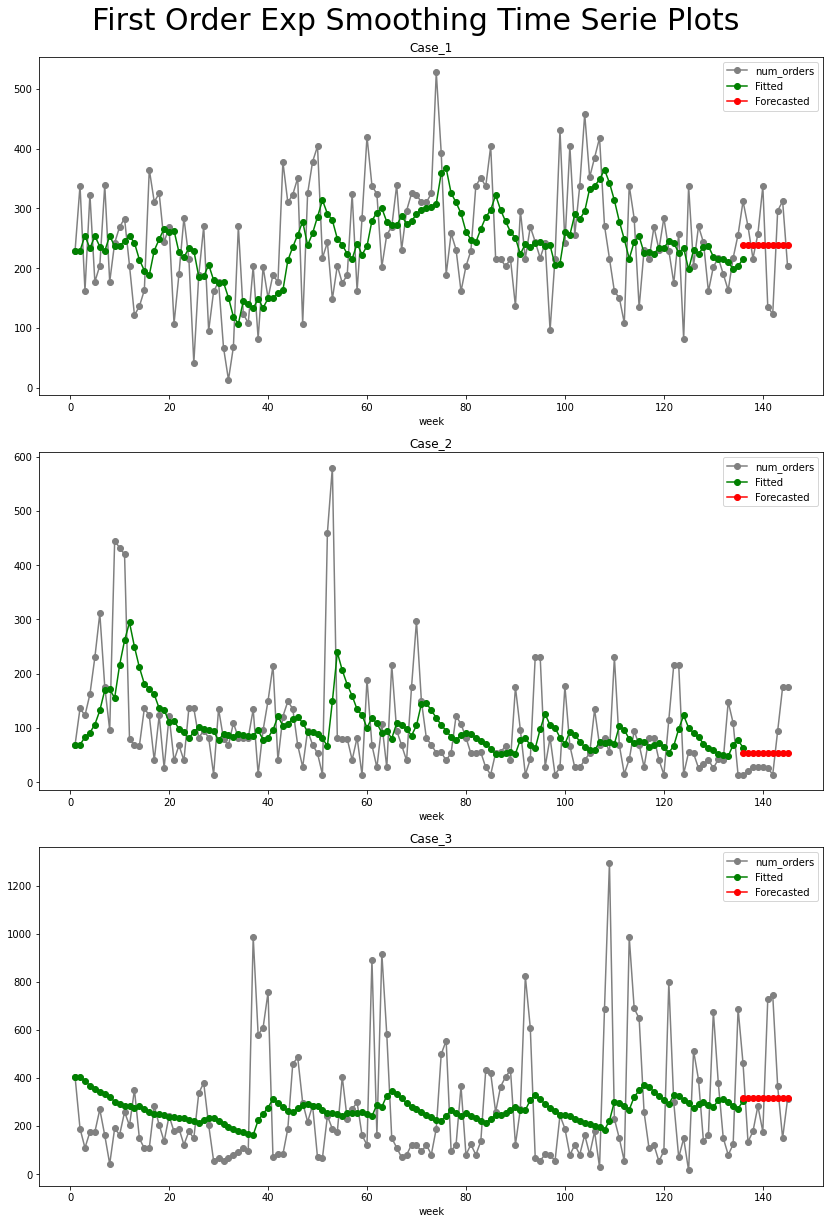

In [15]:
# Plot Actual, Fitted and Forecasted Values
fig , axs = plt.subplots(nrows = n_cases, ncols = 1, figsize = (13, n_cases * 6))

for i in range(n_cases):
    data = cases_data[f'Case_{i + 1}']
    fitted_model = fitted_models[f'Case_{i + 1}']
    
    data.plot(marker = 'o', color = 'gray', ax = axs[i], label = 'Actual')
    fitted_model.fittedvalues.plot(marker = 'o', ax = axs[i], color = 'green', label = 'Fitted')
    fitted_model.forecast(10).plot(marker = 'o', ax = axs[i], color = 'red', label = 'Forecasted')
    axs[i].set_title(f'Case_{i + 1}')
    axs[i].legend()

plt.tight_layout(pad = 6, h_pad = 1)
plt.suptitle('First Order Exp Smoothing Time Serie Plots', fontsize = 30)
plt.savefig('ts_figures/First_Order_Exp_Smoothing_TS_Plots.jpg', dpi = 300)
plt.show()

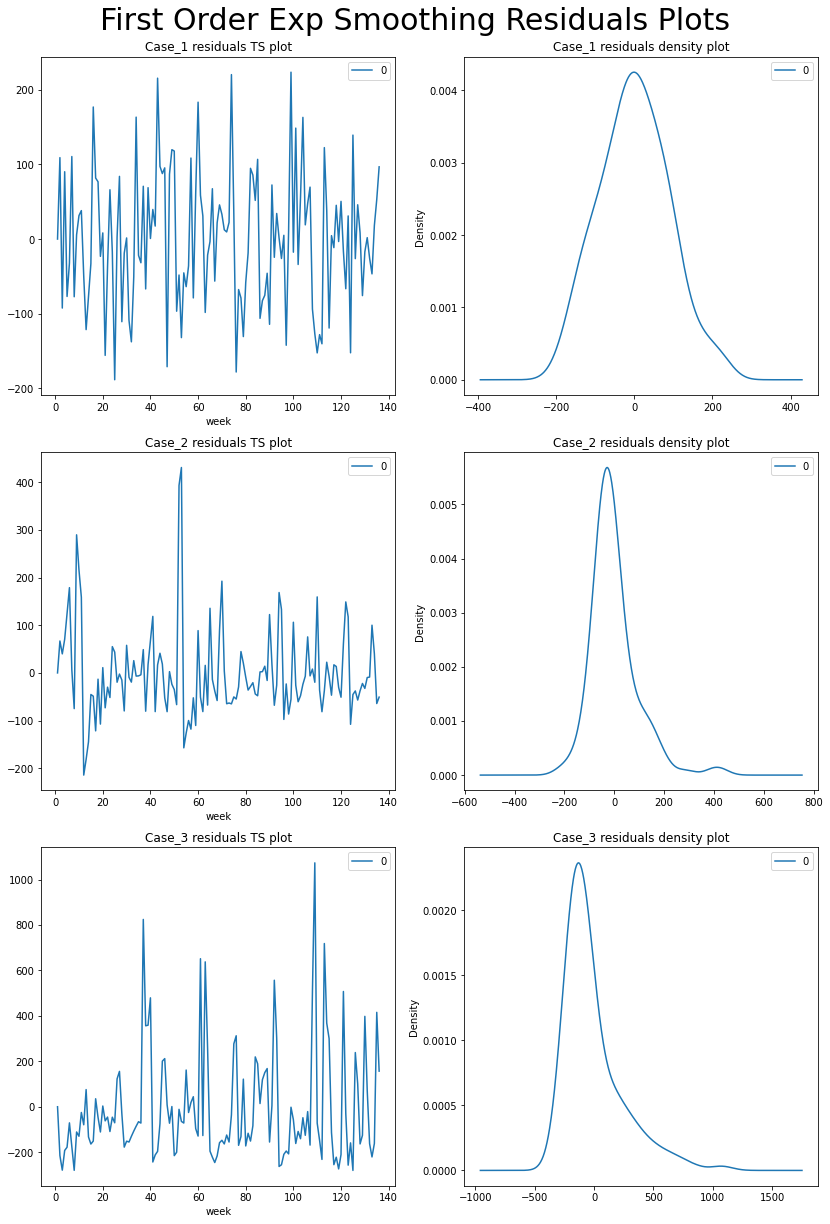

In [16]:
# Plot Residuals
fig , axs = plt.subplots(nrows = n_cases, ncols = 2, figsize = (13, n_cases * 6))

for i in range(n_cases):
    fitted_model = fitted_models[f'Case_{i + 1}']
    residuals = pd.DataFrame(fitted_model.resid)

    residuals.plot(title = f'Case_{i + 1} residuals TS plot', ax = axs[i, 0])
    residuals.plot(kind = 'kde', title = f'Case_{i + 1} residuals density plot', ax = axs[i, 1])

plt.tight_layout(pad = 6, h_pad = 1, w_pad = 1)
plt.suptitle('First Order Exp Smoothing Residuals Plots', fontsize = 30)
plt.savefig('ts_figures/First_Order_Exp_Smoothing_Residuals_Plots.jpg', dpi = 300)
plt.show()

### 2.2. Second Order Exponential Smoothing

In [17]:
# Fit Models
fitted_models = {}

for i in range(n_cases):
    df = data_['train'][f'Case_{i + 1}'].copy()
    
    model = ExponentialSmoothing(df)
    fitted_model = model.fit()
    fitted_models[f'Case_{i + 1}'] = fitted_model

    summary = fitted_model.summary()
    print(f'Case_{i + 1} fitted model summary:')
    print(summary)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Case_1 fitted model summary:
                       ExponentialSmoothing Model Results                       
Dep. Variable:               num_orders   No. Observations:                  136
Model:             ExponentialSmoothing   SSE                        1055281.754
Optimized:                         True   AIC                           1222.106
Trend:                             None   BIC                           1227.932
Seasonal:                          None   AICC                          1222.412
Seasonal Periods:                  None   Date:                 Sat, 24 Jun 2023
Box-Cox:                          False   Time:                         23:06:36
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.2330496                alpha                 True
initi

In [18]:
# Model Evaluation
metrics_names = ['ME', 'MSE', 'RMSE', 'MAE', 'MAPE', 'MME', 'R-Squared']
indices = pd.MultiIndex.from_product([list(cases_data.keys()), ['train', 'test']], 
                                    names = ['Cases', 'sets'])

results = pd.DataFrame(columns = metrics_names, index = indices)

for i in range(n_cases):
    fitted_model = fitted_models[f'Case_{i + 1}']

    # train set evaluation
    train_actual = data_['train'][f'Case_{i + 1}']
    fitted = fitted_model.fittedvalues
    results.loc[(f'Case_{i + 1}', 'train'), :] = evaluate(train_actual, fitted)

    # test set evaluation
    test_actual = data_['test'][f'Case_{i + 1}']
    forecasted = fitted_model.forecast(10)
    results.loc[(f'Case_{i + 1}', 'test'), :] = evaluate(test_actual, forecasted)
    
results.round(2)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In t

ME           MSE        RMSE         MAE      MAPE  \
Cases  sets                                                               
Case_1 train  -0.299183   7759.424664   88.087597   70.654423  0.446452   
       test    8.233528   5106.680977   71.461045   63.126706  0.312808   
Case_2 train  -4.980234   8658.859231   93.052992    65.36806  1.193809   
       test    6.028537   3831.703255   61.900753   50.508585  1.352183   
Case_3 train   6.526738  56028.176977  236.702719  175.421215  1.219059   
       test   90.197666  54566.908877   233.59561  173.159533  0.492584   

                   MME R-Squared  
Cases  sets                       
Case_1 train  0.167692  0.085425  
       test   0.636785 -0.013454  
Case_2 train  0.123045  0.029309  
       test   0.416639 -0.009576  
Case_3 train  0.166951 -0.003958  
       test   0.359776 -0.175218

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In t

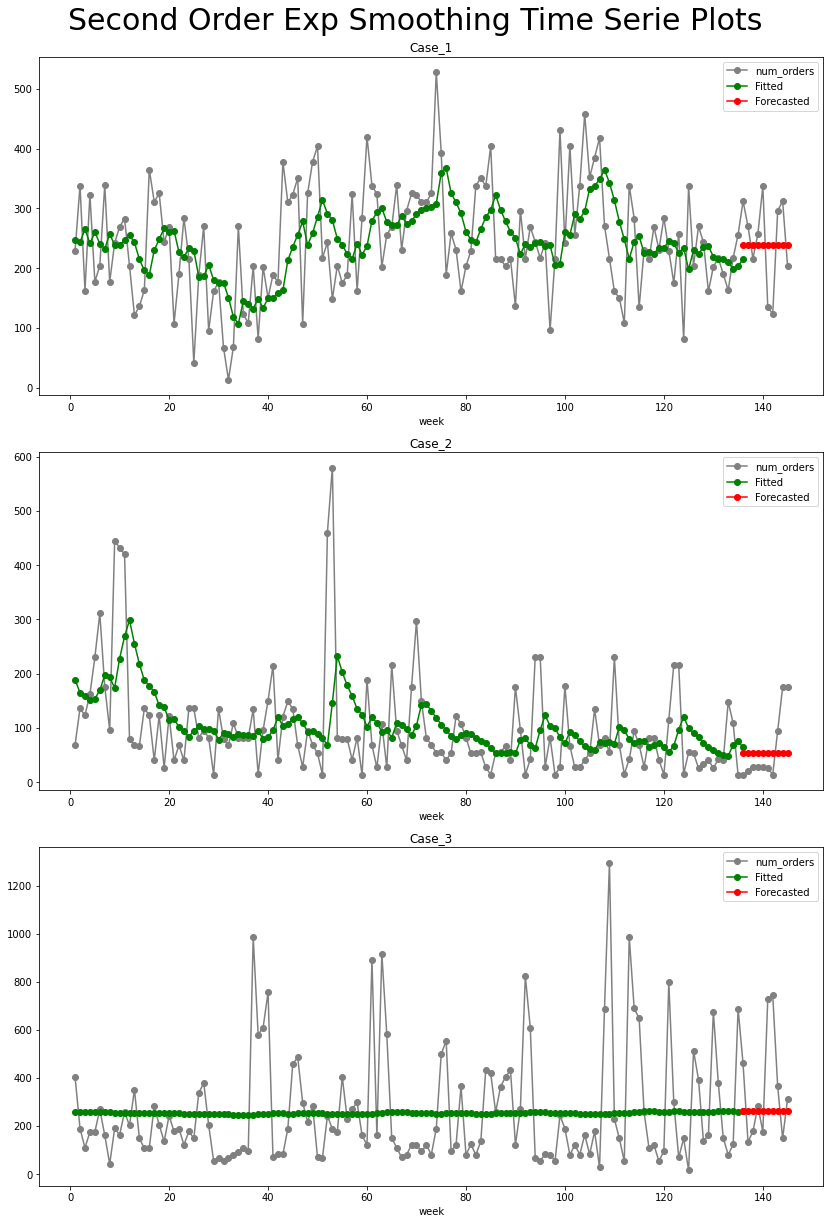

In [19]:
# Plot Actual, Fitted and Forecasted Values
fig , axs = plt.subplots(nrows = n_cases, ncols = 1, figsize = (13, n_cases * 6))

for i in range(n_cases):
    data = cases_data[f'Case_{i + 1}']
    fitted_model = fitted_models[f'Case_{i + 1}']
    
    data.plot(marker = 'o', color = 'gray', ax = axs[i], label = 'Actual')
    fitted_model.fittedvalues.plot(marker = 'o', ax = axs[i], color = 'green', label = 'Fitted')
    fitted_model.forecast(10).plot(marker = 'o', ax = axs[i], color = 'red', label = 'Forecasted')
    axs[i].set_title(f'Case_{i + 1}')
    axs[i].legend()

plt.tight_layout(pad = 6, h_pad = 1)
plt.suptitle('Second Order Exp Smoothing Time Serie Plots', fontsize = 30)
plt.savefig('ts_figures/Second_Order_Exp_Smoothing_TS_Plots.jpg', dpi = 300)
plt.show()

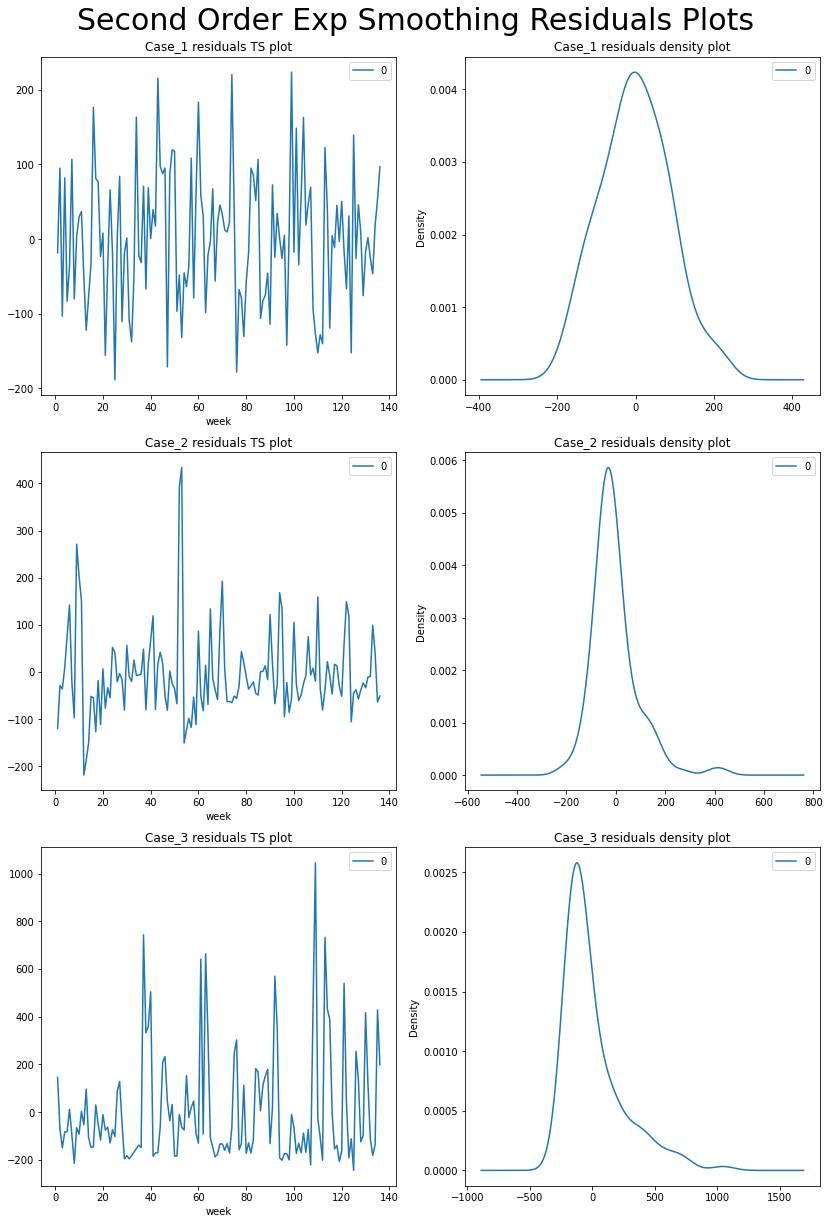

In [20]:
# Plot Residuals
fig , axs = plt.subplots(nrows = n_cases, ncols = 2, figsize = (13, n_cases * 6))

for i in range(n_cases):
    fitted_model = fitted_models[f'Case_{i + 1}']
    residuals = pd.DataFrame(fitted_model.resid)

    residuals.plot(title = f'Case_{i + 1} residuals TS plot', ax = axs[i, 0])
    residuals.plot(kind = 'kde', title = f'Case_{i + 1} residuals density plot', ax = axs[i, 1])

plt.tight_layout(pad = 6, h_pad = 1, w_pad = 1)
plt.suptitle('Second Order Exp Smoothing Residuals Plots', fontsize = 30)
plt.savefig('ts_figures/Second_Order_Exp_Smoothing_Residuals_Plots.jpg', dpi = 300)
plt.show()

### 2.3. Stationarity

In [21]:
for i in range(n_cases):
    df = cases_data[f'Case_{i + 1}'].copy()
    result = adfuller(df['num_orders'])
    print(f'Case {i + 1}: P-value: {round(result[1], 4)}, Correlation lags: {result[2]}')


Case 1: P-value: 0.0, Correlation lags: 0
Case 2: P-value: 0.0, Correlation lags: 1
Case 3: P-value: 0.0, Correlation lags: 1


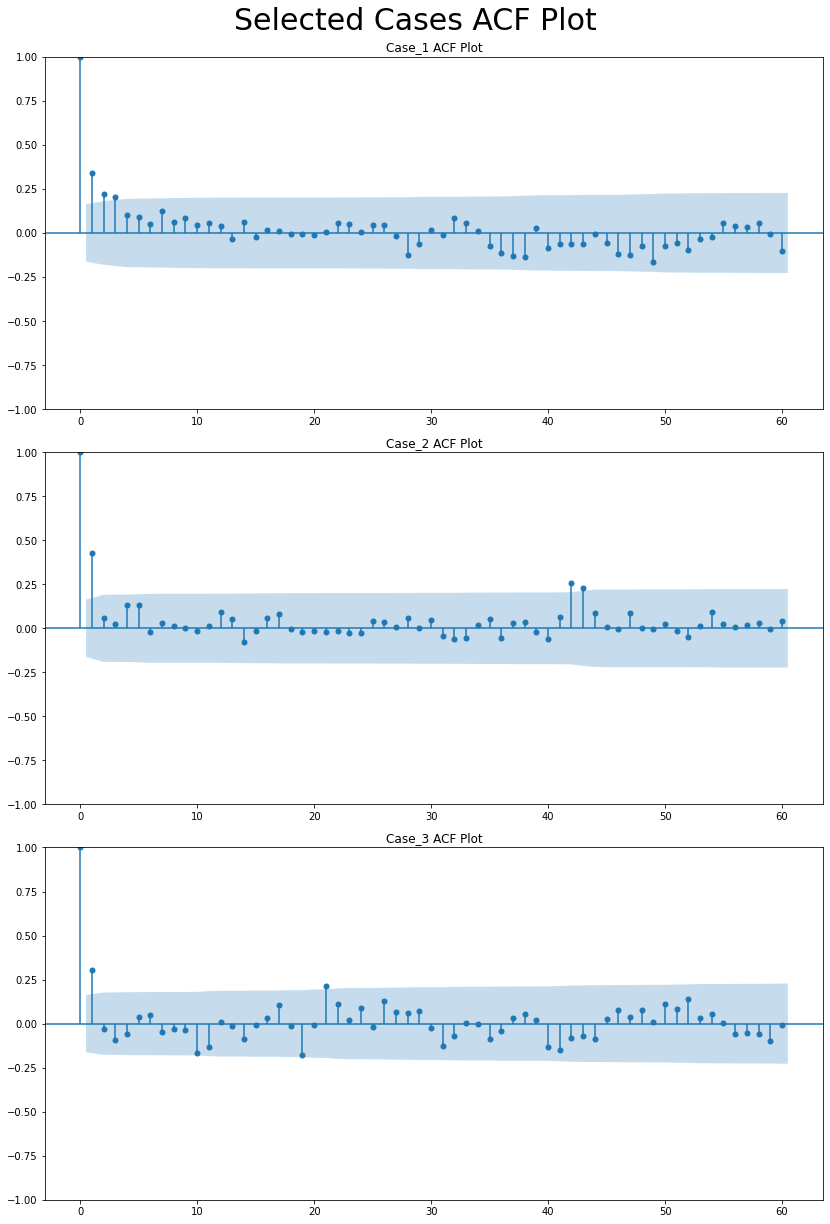

In [22]:
# ACF Plot of Cases
fig , axs = plt.subplots(nrows = n_cases, ncols = 1, figsize = (13, n_cases * 6))

for i in range(n_cases):
    data = cases_data[f'Case_{i + 1}']
    plot_acf(data, lags = 60, ax = axs[i])
    axs[i].set_title(f'Case_{i + 1} ACF Plot')

plt.tight_layout(pad = 6, h_pad = 1)
plt.suptitle('Selected Cases ACF Plot', fontsize = 30)
plt.savefig('ts_figures/ACF_Plot_of_Cases.jpg', dpi = 300)
plt.show()

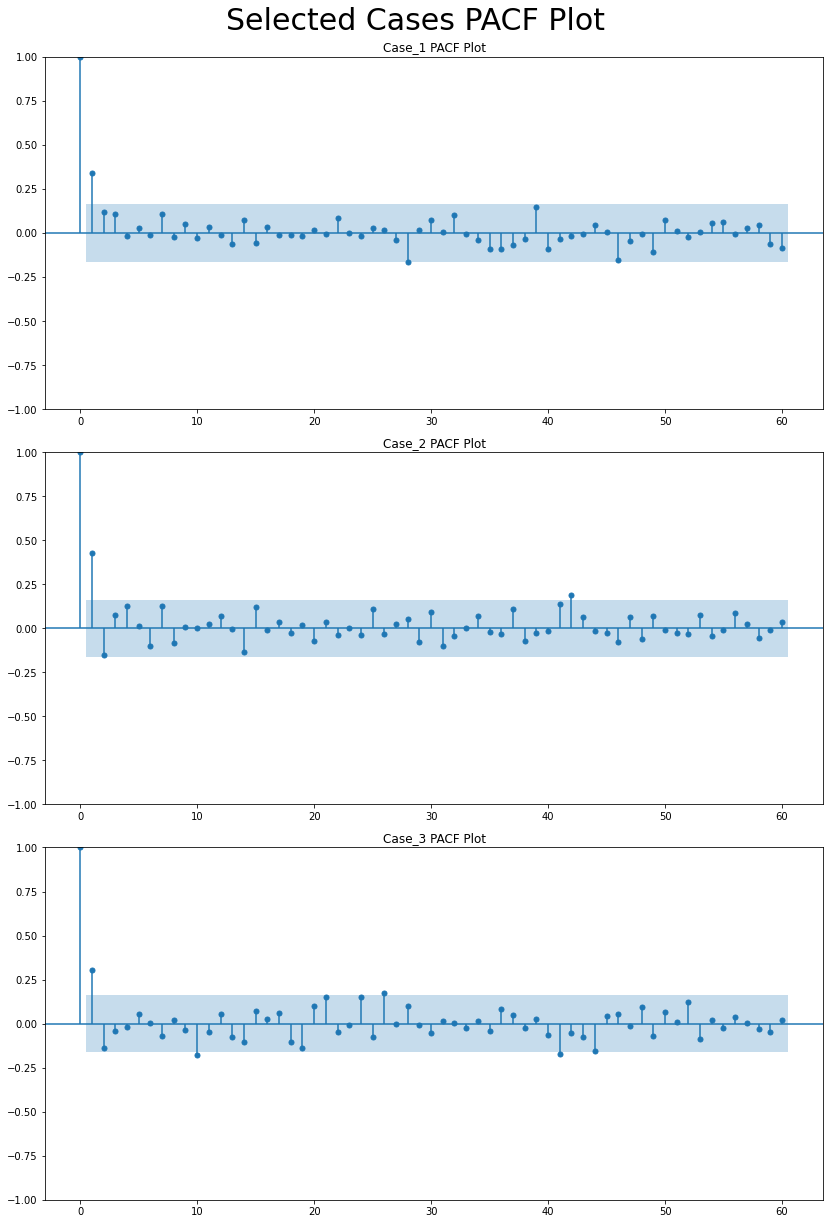

In [23]:
# PACF Plot of Cases
fig , axs = plt.subplots(nrows = n_cases, ncols = 1, figsize = (13, n_cases * 6))

for i in range(n_cases):
    data = cases_data[f'Case_{i + 1}']
    plot_pacf(data, lags = 60, ax = axs[i])
    axs[i].set_title(f'Case_{i + 1} PACF Plot')

plt.tight_layout(pad = 6, h_pad = 1)
plt.suptitle('Selected Cases PACF Plot', fontsize = 30)
plt.savefig('ts_figures/PACF_Plot_of_Cases.jpg', dpi = 300)
plt.show()

### 2.4. ARIMA

In [24]:
# Fit model for case 1
df = data_['train']['Case_1']
model = ARIMA(df, order = (1, 0, 0))
fitted_model = model.fit()
fitted_model.summary()

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             num_orders   No. Observations:                  136
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -798.978
Date:                Sat, 24 Jun 2023   AIC                           1603.956
Time:                        23:06:50   BIC                           1612.694
Sample:                             0   HQIC                          1607.507
                                - 136                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        243.7241     11.495     21.203      0.000     221.195     266.253
ar.L1          0.3537      0.083      4.268      0.000       0.191       0.516
sigma2      7410.6949    947.748      7.819      0.000    5553.144    9268.246
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):                 0.65
Prob(Q):                              0.54   Prob(JB):                         0.72
Heteroskedasticity (H):               0.85   Skew:                             0.15
Prob(H) (two-sided):                  0.60   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
# Auto ARIMA for case 1
model = pm.auto_arima(df, start_p = 1, start_q = 1, test = 'adf', 
                      max_p = 3, max_q = 3, m = 1, d = 0,
                      D = 0, trace = True, error_action = 'ignore',
                      stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1602.113, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1620.202, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1603.957, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1608.586, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1900.984, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1604.490, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1604.598, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1606.403, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1602.781, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1605.380, Time=0.33 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1613.697, Time=0.10 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 1.631 seconds


In [26]:
# Fit model for case 2
df = data_['train']['Case_2']
model = ARIMA(df, order = (0, 0, 1))
fitted_model = model.fit()
fitted_model.summary()

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             num_orders   No. Observations:                  136
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -797.474
Date:                Sat, 24 Jun 2023   AIC                           1600.947
Time:                        23:06:52   BIC                           1609.685
Sample:                             0   HQIC                          1604.498
                                - 136                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        100.3050     15.256      6.575      0.000      70.404     130.206
ma.L1          0.4491      0.048      9.332      0.000       0.355       0.543
sigma2      7243.5058    657.140     11.023      0.000    5955.534    8531.477
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):               219.87
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                             1.85
Prob(H) (two-sided):                  0.02   Kurtosis:                         8.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
# Auto ARIMA for case 2
model = pm.auto_arima(df, start_p = 1, start_q = 1, test = 'adf', 
                      max_p = 3, max_q = 3, m = 1, d = 0,
                      D = 0, trace = True, error_action = 'ignore',
                      stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1602.298, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1627.019, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1603.678, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1600.947, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1727.833, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1602.121, Time=0.27 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1604.411, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1661.003, Time=0.06 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 1.148 seconds


In [28]:
# Fit model for case 3
df = data_['train']['Case_3']
model = ARIMA(df, order = (1, 0, 0))
fitted_model = model.fit()
fitted_model.summary()

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             num_orders   No. Observations:                  136
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -929.915
Date:                Sat, 24 Jun 2023   AIC                           1865.829
Time:                        23:06:53   BIC                           1874.567
Sample:                             0   HQIC                          1869.380
                                - 136                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        261.6109     45.252      5.781      0.000     172.918     350.304
ar.L1          0.2970      0.070      4.255      0.000       0.160       0.434
sigma2      5.085e+04   6015.107      8.454      0.000    3.91e+04    6.26e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):               154.81
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               2.63   Skew:                             1.86
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
# Auto ARIMA for case 3
model = pm.auto_arima(df, start_p = 1, start_q = 1, test = 'adf', 
                      max_p = 3, max_q = 3, m = 1, d = 0,
                      D = 0, trace = True, error_action = 'ignore',
                      stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1866.767, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1876.385, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1865.834, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1864.454, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1982.629, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1866.408, Time=0.31 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1868.451, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1930.046, Time=0.08 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.975 seconds


In [30]:
# Auto ARIMA for case 1

In [31]:
# Fit Models
fitted_models = {}
orders = ((1, 0, 0), (0, 0, 1), (1, 0, 0))

for i in range(n_cases):
    df = data_['train'][f'Case_{i + 1}'].copy()
    
    model = ARIMA(df, order = orders[i])
    fitted_model = model.fit()
    fitted_models[f'Case_{i + 1}'] = fitted_model

    summary = fitted_model.summary()
    print(f'Case_{i + 1} fitted model summary:')
    print(summary)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Case_1 fitted model summary:
                               SARIMAX Results                                
Dep. Variable:             num_orders   No. Observations:                  136
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -798.978
Date:                Sat, 24 Jun 2023   AIC                           1603.956
Time:                        23:06:55   BIC                           1612.694
Sample:                             0   HQIC                          1607.507
                                - 136                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        243.7241     11.495     21.203      0.000     221.195     266.253
ar.L1          0.3537      0.083      4.268      0.000       0.191       0.516
sigma2      7410.6949  

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Case_2 fitted model summary:
                               SARIMAX Results                                
Dep. Variable:             num_orders   No. Observations:                  136
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -797.474
Date:                Sat, 24 Jun 2023   AIC                           1600.947
Time:                        23:06:55   BIC                           1609.685
Sample:                             0   HQIC                          1604.498
                                - 136                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        100.3050     15.256      6.575      0.000      70.404     130.206
ma.L1          0.4491      0.048      9.332      0.000       0.355       0.543
sigma2      7243.5058  

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [32]:
# Model Evaluation
metrics_names = ['ME', 'MSE', 'RMSE', 'MAE', 'MAPE', 'MME', 'R-Squared']
indices = pd.MultiIndex.from_product([list(cases_data.keys()), ['train', 'test']], 
                                    names = ['Cases', 'sets'])

results = pd.DataFrame(columns = metrics_names, index = indices)

for i in range(n_cases):
    fitted_model = fitted_models[f'Case_{i + 1}']

    # train set evaluation
    train_actual = data_['train'][f'Case_{i + 1}']
    fitted = fitted_model.fittedvalues
    results.loc[(f'Case_{i + 1}', 'train'), :] = evaluate(train_actual, fitted)

    # test set evaluation
    test_actual = data_['test'][f'Case_{i + 1}']
    forecasted = fitted_model.forecast(10)
    results.loc[(f'Case_{i + 1}', 'test'), :] = evaluate(test_actual, forecasted)
    
results.round(2)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In t

ME           MSE        RMSE         MAE      MAPE  \
Cases  sets                                                               
Case_1 train   0.146811   7411.937715   86.092611   69.218375   0.47144   
       test   -1.360479   4747.216559   68.900048   58.859612  0.305684   
Case_2 train  -0.071824   7246.480667   85.126263   60.634143  1.146359   
       test  -38.148517   5080.077601   71.274663   68.026501  2.700658   
Case_3 train  -0.311453  50864.395471  225.531363  162.227293  1.110634   
       test   82.906694  53326.858201  230.926088  169.628136  0.494247   

                   MME R-Squared  
Cases  sets                       
Case_1 train  0.189182  0.126382  
       test   0.631041  0.057884  
Case_2 train  0.110423  0.187642  
       test    0.69231 -0.338497  
Case_3 train  0.146595  0.088571  
       test   0.351642 -0.148511

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In t

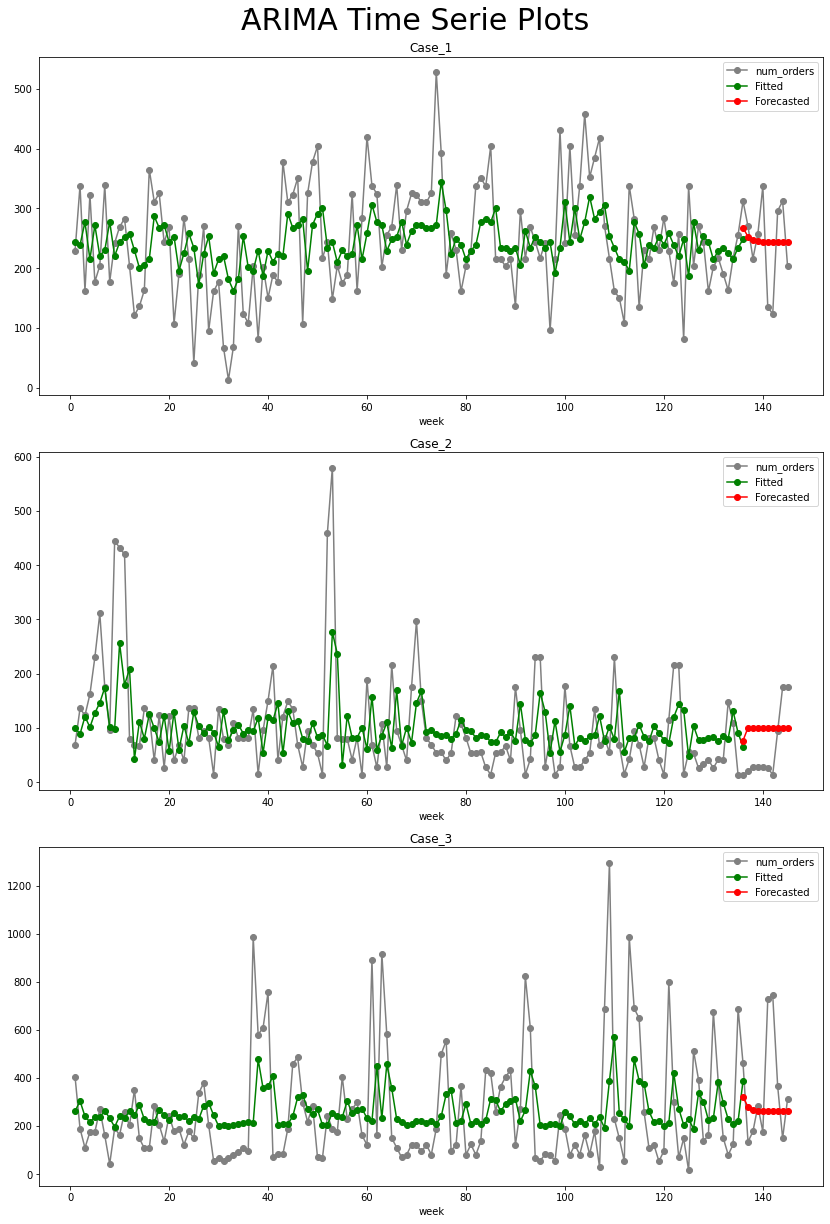

In [33]:
# Plot Actual, Fitted and Forecasted Values
fig , axs = plt.subplots(nrows = n_cases, ncols = 1, figsize = (13, n_cases * 6))

for i in range(n_cases):
    data = cases_data[f'Case_{i + 1}']
    fitted_model = fitted_models[f'Case_{i + 1}']
    
    data.plot(marker = 'o', color = 'gray', ax = axs[i], label = 'Actual')
    fitted_model.fittedvalues.plot(marker = 'o', ax = axs[i], color = 'green', label = 'Fitted')
    fitted_model.forecast(10).plot(marker = 'o', ax = axs[i], color = 'red', label = 'Forecasted')
    axs[i].set_title(f'Case_{i + 1}')
    axs[i].legend()

plt.tight_layout(pad = 6, h_pad = 1)
plt.suptitle('َARIMA Time Serie Plots', fontsize = 30)
plt.savefig('ts_figures/ARIMA_TS_Plots.jpg', dpi = 300)
plt.show()

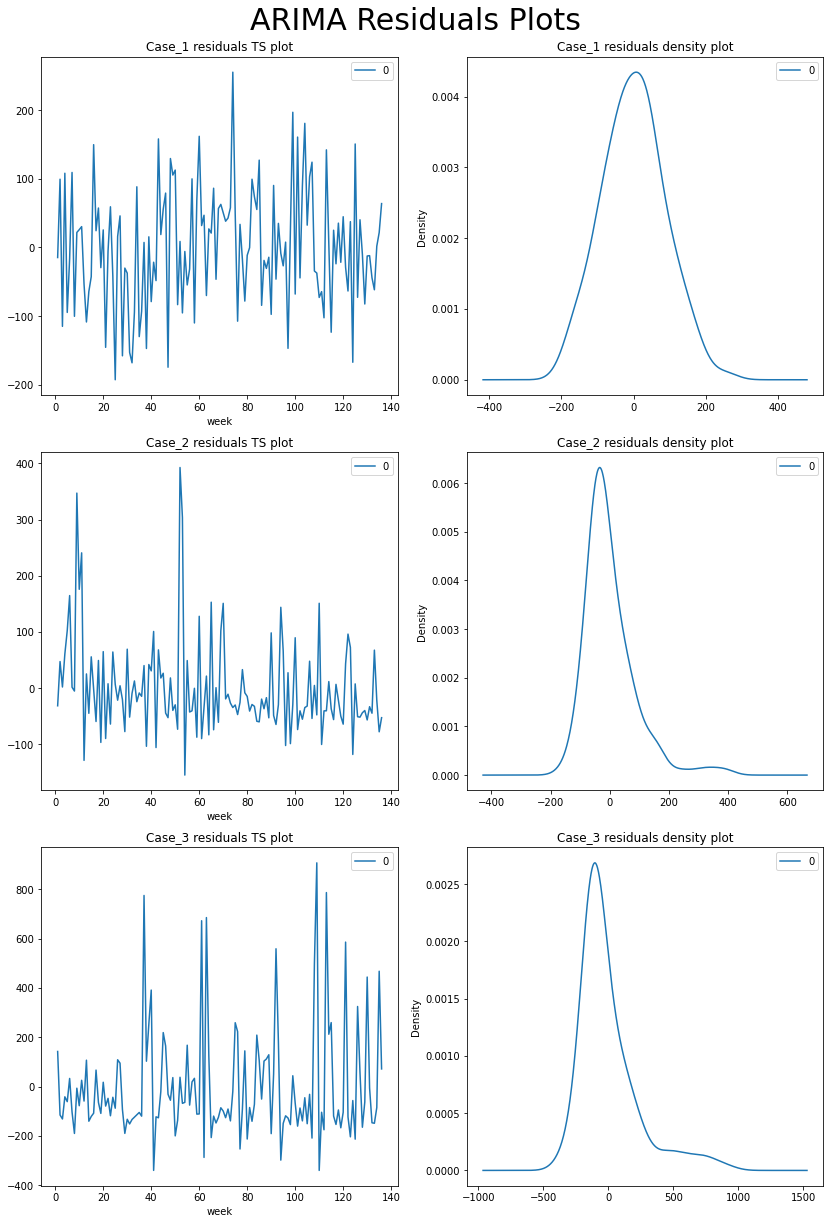

In [34]:
# Plot Residuals
fig , axs = plt.subplots(nrows = n_cases, ncols = 2, figsize = (13, n_cases * 6))

for i in range(n_cases):
    fitted_model = fitted_models[f'Case_{i + 1}']
    residuals = pd.DataFrame(fitted_model.resid)

    residuals.plot(title = f'Case_{i + 1} residuals TS plot', ax = axs[i, 0])
    residuals.plot(kind = 'kde', title = f'Case_{i + 1} residuals density plot', ax = axs[i, 1])

plt.tight_layout(pad = 6, h_pad = 1, w_pad = 1)
plt.suptitle('ARIMA Residuals Plots', fontsize = 30)
plt.savefig('ts_figures/ARIMA_Residuals_Plots.jpg', dpi = 300)
plt.show()